# **Forest Fire Detection Using Convolutional Neural Network**

---



link to image dataset: https://www.kaggle.com/datasets/brsdincer/wildfire-detection-image-data

In [1]:
import tensorflow as tf
import numpy as np
import keras
import os
import cv2
import warnings
warnings.filterwarnings(action='ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
%matplotlib inline

## Image Pre-Processing

In [2]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory("./forest_fire/Training and Validation/",
                                          target_size=(150,150),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
test_dataset = test.flow_from_directory("./forest_fire/Testing/",
                                          target_size=(150,150),
                                          batch_size =32,
                                          class_mode = 'binary')

Found 1832 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [3]:
test_dataset.class_indices

{'fire': 0, 'nofire': 1}

## Building and Compiling the Model

In [4]:
def cnn_model(layers, units, dropout): 
    from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
        
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Flatten())
    
    for _ in range(layers):
        model.add(Dense(units, activation= 'relu'))
        model.add(Dropout(dropout))
    
    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

## Hyper-Parameter Tuning

In [54]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

KC = KerasClassifier(build_fn=cnn_model, verbose=1)
layers = [1, 2]
units = [512]
dropout = [0.2]
params = dict(layers=layers, units=units, dropout=dropout)
X_train, y_train = next(train_dataset)
grid = GridSearchCV(estimator=KC, param_grid=params, verbose=1, cv = 3)
grid_results = grid.fit(X_train, y_train)
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
1/1 [==============================] - 1s 921ms/step - loss: 0.7045 - accuracy: 0.5000
Best: 0.3454545537630717, using {'dropout': 0.2, 'layers': 1, 'units': 512}


## Fitting the model

In [6]:
best_model = cnn_model(**grid_results.best_params_)
history = best_model.fit(train_dataset, epochs=10)

Epoch 1/10
58/58 [==============================] - 29s 491ms/step - loss: 0.3238 - accuracy: 0.8772
Epoch 2/10
58/58 [==============================] - 28s 488ms/step - loss: 0.1575 - accuracy: 0.9476
Epoch 3/10
58/58 [==============================] - 30s 519ms/step - loss: 0.1300 - accuracy: 0.9552
Epoch 4/10
58/58 [==============================] - 31s 535ms/step - loss: 0.1099 - accuracy: 0.9656
Epoch 5/10
58/58 [==============================] - 29s 496ms/step - loss: 0.0892 - accuracy: 0.9711
Epoch 6/10
58/58 [==============================] - 31s 526ms/step - loss: 0.0833 - accuracy: 0.9705
Epoch 7/10
58/58 [==============================] - 30s 524ms/step - loss: 0.0482 - accuracy: 0.9842
Epoch 8/10
58/58 [==============================] - 30s 516ms/step - loss: 0.0422 - accuracy: 0.9885
Epoch 9/10
58/58 [==============================] - 31s 537ms/step - loss: 0.0264 - accuracy: 0.9918
Epoch 10/10
58/58 [==============================] - 32s 553ms/step - loss: 0.0516 - accura

## Predicting on Test Dataset

In [62]:
predictions = best_model.predict(test_dataset)
predictions = np.round(predictions)

In [64]:
predictions

array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [65]:
print(len(predictions))

68


In [77]:
X_test, y_test = next(test_dataset)
los, acc = best_model.evaluate(X_test, y_test, batch_size = 32, verbose=0)
print("\nTest Accuracy: %.1f%%" % (100.0 * acc))
print("Test Loss: %.1f%%" % (100.0 * los))


Test Accuracy: 93.8%
Test Loss: 18.6%


### Plotting loss per iteration

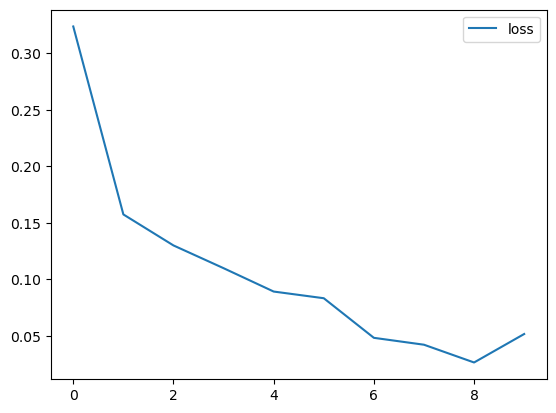

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.legend()

### Plotting accuracy per iteration

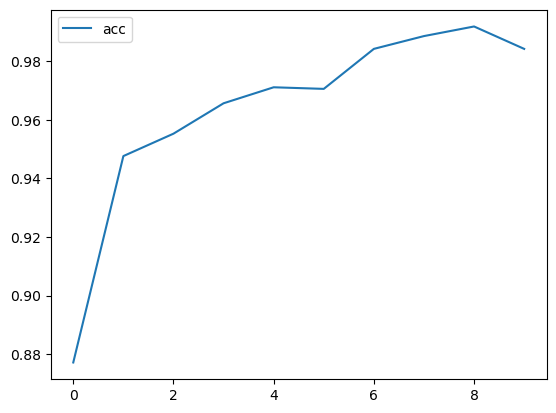

In [12]:
plt.plot(history.history['accuracy'], label='acc')
plt.legend()

### Making a function to see any image from dataset with predicted label

In [16]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(150,150))
    plt.imshow(img1)
    Y = image.img_to_array(img1)
    X = np.expand_dims(Y,axis=0)
    val = best_model.predict(X)
    print(val)
    if val == 1:
        plt.xlabel("No Fire",fontsize=30)
    elif val == 0:
        plt.xlabel("Fire",fontsize=30)

1/1 [==============================] - 0s 80ms/step
[[0.]]


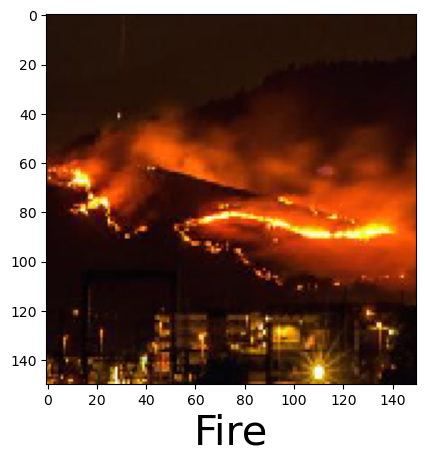

In [17]:
predictImage("./forest_fire/Testing/fire/abc182.jpg")

1/1 [==============================] - 0s 40ms/step
[[0.]]


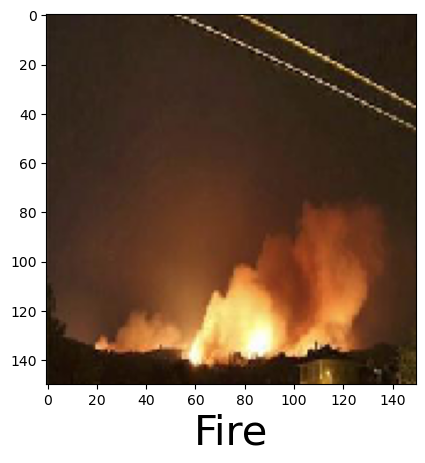

In [18]:
predictImage('./forest_fire/Testing/fire/abc190.jpg')

1/1 [==============================] - 0s 36ms/step
[[1.]]


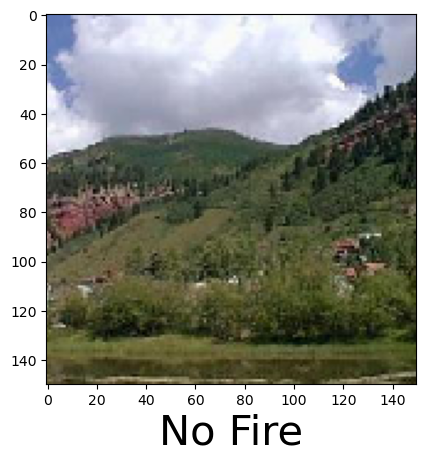

In [19]:
predictImage('./forest_fire/Testing/nofire/abc346.jpg')

1/1 [==============================] - 0s 21ms/step
[[1.]]


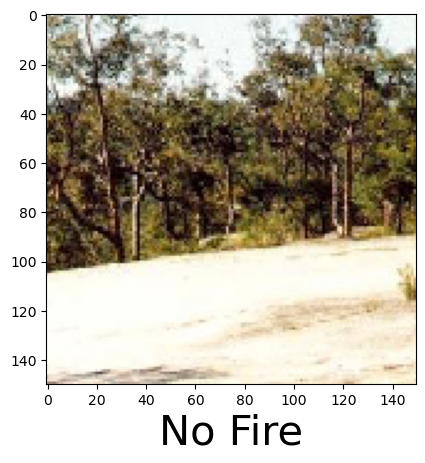

In [20]:
predictImage('./forest_fire/Testing/nofire/abc361.jpg')

## Notes


1.   Transfer Learning can be used to reduce the learning/training time significantly.